In [1]:
import sys

ENV_COLAB = 'google.colab' in sys.modules
FILE_NAME = 'DATASET_THESIS_2022.csv'

if ENV_COLAB:

  DIR = '/content/drive/My Drive/Thesis Project/'
  from google.colab import output, drive
  !pip install feature_engine hyperopt shap xgboost

  output.enable_custom_widget_manager()
  drive.mount('/content/drive/')

else:

  DIR = './'

from tqdm import tqdm
import pickle
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score   
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
    )

# for feature engineering
from feature_engine import imputation as mdi
from feature_engine import encoding as ce
from feature_engine import discretisation as disc
from feature_engine import transformation as t

import matplotlib.pyplot as plt
import seaborn as sns
import shap

from hyperopt import fmin, tpe, Trials
from hyperopt import STATUS_OK

external_link = 'https://drive.google.com/file/d/1zqpDIP0v0JTjFhmZybAyNx3Xrqv1Vl_w/view?usp=share_link'

df_data = pd.concat([chunk for chunk in tqdm(pd.read_csv(external_link, chunksize=1000), desc='Loading data')])
y = df_data.TARGET
X = df_data.drop(columns=['TARGET'])

X.columns = [col.replace(' ', '') for col in X.columns]
feat_names = X.columns


Loading data: 154it [00:26,  4.85it/s]


In [2]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state= 42)

# pipe = Pipeline([
#                 ('imputer', mdi.MeanMedianImputer(imputation_method='median')),
#             ])
# X_train = pipe.fit_transform(X_train)
# X_test =  pipe.transform(X_test)

d_train = xgb.DMatrix(X_train, y_train)
d_test = xgb.DMatrix(X_test, y_test)


In [14]:
# Manually random search 
params ={
    'booster' : 'gbtree',
    'n_estimators': 200,
    'eta': 0.2,
    'colsample_bytree':0.7, 
    'colsample_bylevel':0.7, 
    'colsample_bynode':0.7,
    'n_job': 2,
    'early_stopping_rounds' : 30,
    'Objective': 'binary:logistic',
    'eval_metric': ['auc','logloss']
    }

evals_result = {}

mdl_xgb = xgb.train(
    params= params, dtrain = d_train, num_boost_round = 100,
    evals = [(d_train, 'train'), (d_test, 'eval')], evals_result = evals_result, 
    verbose_eval = 50
    )


[02:50:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-auc:0.734216	train-logloss:0.560753	eval-auc:0.717237	eval-logloss:0.561645
[02:50:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[02:50:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[02:50:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[02:50:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[02:51:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[02:51:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[02:51:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[02:51:27] 

In [43]:
from skopt import BayesSearchCV

estimator = xgb.XGBClassifier(random_state= 43)

fit_params = {
    'early_stopping_rounds': 10,
    'eval_set':[(X_train, y_train)],
    'verbose': 5,
}

search_space = {
    'max_depth': (3, 7),
    'n_estimators': (30, 200),
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'gamma': (1e-9, 0.5, 'log-uniform'),
}


opt = BayesSearchCV(
    estimator=estimator, search_spaces=search_space,
    fit_params=fit_params, cv=3, scoring="roc_auc",
    random_state=43, verbose=5,
    n_iter=20, n_jobs = -1,
)

opt.fit(X_train, y_train)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=3, estimator=XGBClassifier(random_state=43),
              fit_params={'early_stopping_rounds': 10,
                          'eval_set': [(        NEW_CREDIT_TO_ANNUITY_RATIO  NEW_EXT_SOURCES_MEAN  DAYS_BIRTH  \
98610                     20.458118              0.301222      -11033   
7082                      34.083333              0.430375      -21892   
71077                     28.109628              0.645379      -22466   
41389                     20.430824              0.512221      -10958   
105009                    34.076193              0.487903      -23339   
...                             ...                   ...         ...   
119879                    34.082031              0.550393      -1027...
121958      382891  

[107401 rows x 842 columns],
                                        98610     0
7082      0
71077     0
41389     0
105009    1
         ..
119879    0
103694    1
131932    0
146867    0
121958    0
Name: TARGET, Length: 107401, dtype: 

In [105]:
# opt.best_estimator_.save_model('xgb_mdl_v1.json')
import pickle
pickle.dump(opt.best_estimator_, open('xgb_mdl_v1.pkl', 'wb'))

In [111]:
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

pdp = partial_dependence(opt.best_estimator_, X_test, 'NEW_EXT_SOURCES_MEAN')


A Bunch will be returned in place of 'predictions' from version 1.1 (renaming of 0.26) with partial dependence results accessible via the 'average' key. In the meantime, pass kind='average' to get the future behaviour.


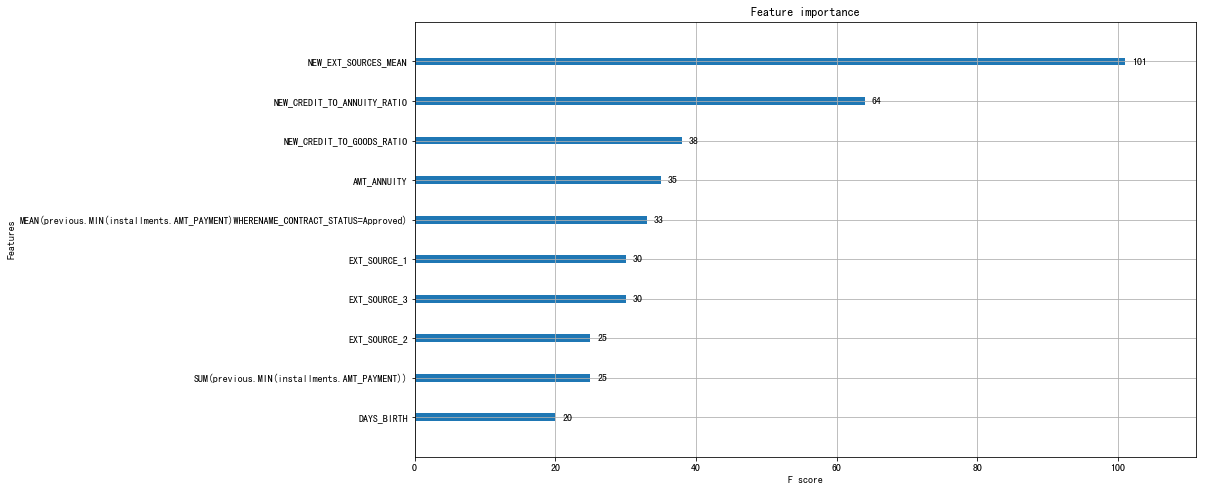

In [123]:

fig, ax = plt.subplots(figsize = (14,8))
xgb.plot_importance(opt.best_estimator_, max_num_features= 10, ax =ax, importance_type= 'weight') 

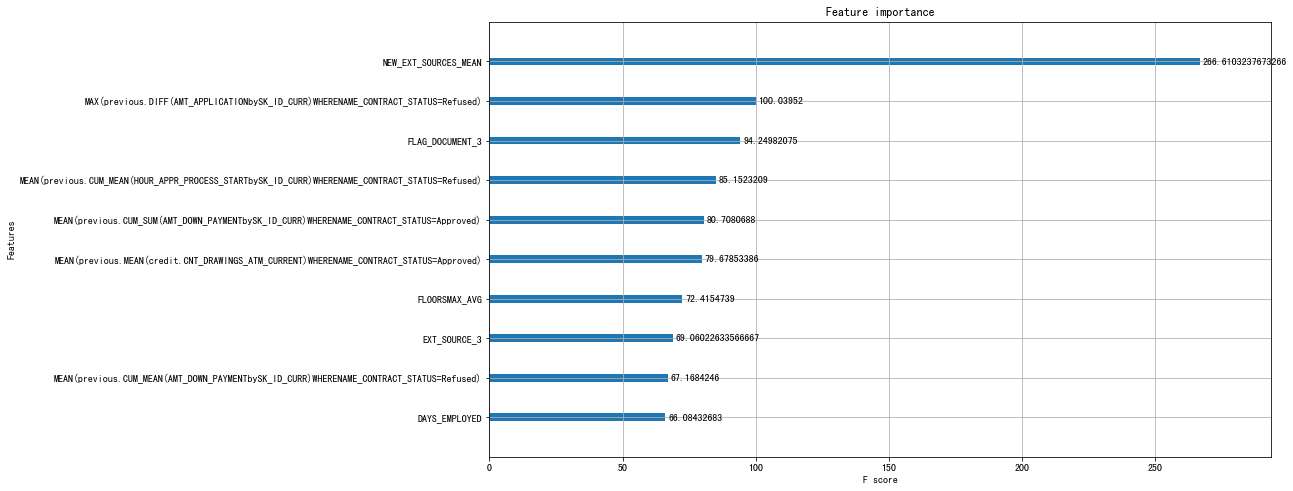

In [122]:

fig, ax = plt.subplots(figsize = (14,8))
xgb.plot_importance(opt.best_estimator_, max_num_features= 10, ax =ax, importance_type= 'gain') 

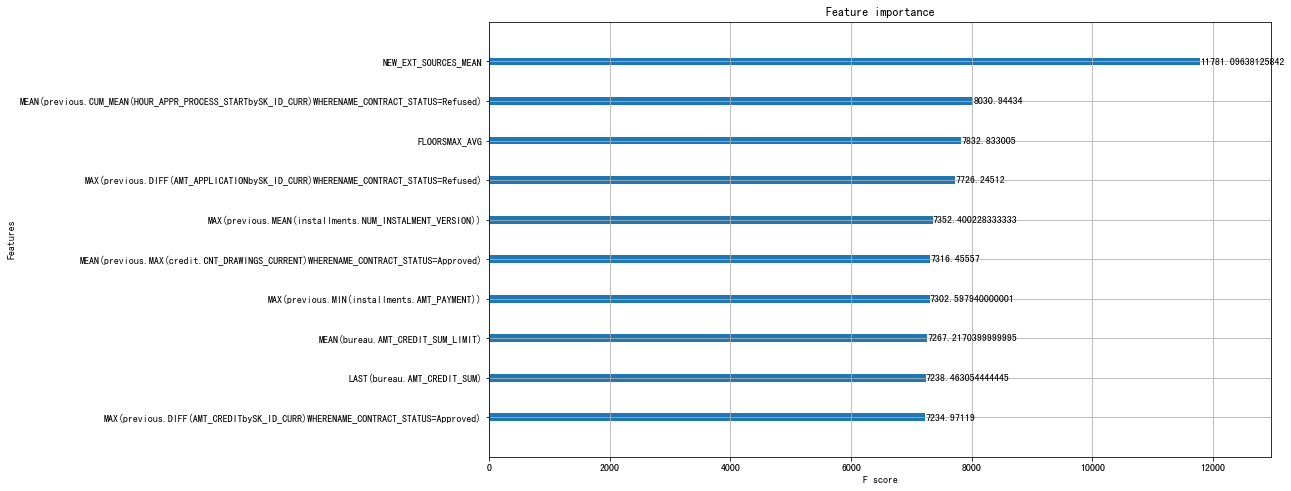

: 

In [124]:

fig, ax = plt.subplots(figsize = (14,8))
xgb.plot_importance(opt.best_estimator_, max_num_features= 10, ax =ax, importance_type= 'cover') 

In [119]:
shap.plots.bar(shap_values)


AssertionError: You must pass an Explanation object, Cohorts object, or dictionary to bar plot!

In [115]:
explainer = shap.TreeExplainer(opt.best_estimator_)
shap_values = explainer.shap_values(X_test)


In [114]:
roc_auc_score(y_test, opt.best_estimator_.predict_proba(X_test)[:,1])

0.7699963468477798

In [120]:
opt.best_params_

OrderedDict([('gamma', 0.49999999999999994),
             ('learning_rate', 0.08203175775371215),
             ('max_depth', 3),
             ('n_estimators', 200)])

Font 'default' does not have a glyph for '-' [U+2212]
Substituting with a dummy symbol.


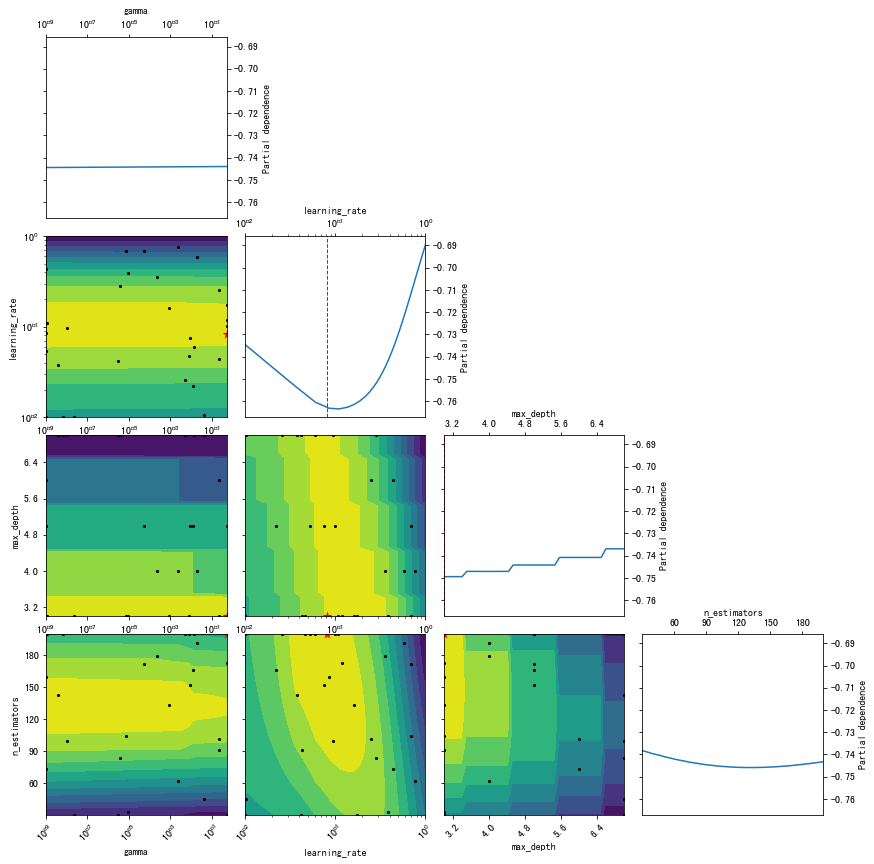

In [49]:
from skopt.plots import plot_objective

_ = plot_objective(opt.optimizer_results_[0],
                   dimensions=["gamma", "learning_rate", "max_depth", "n_estimators"],
                   n_minimum_search=int(1e8), 
                   size = 3
                   )
plt.show()

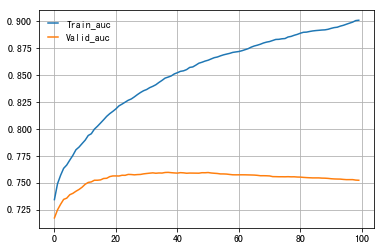

In [22]:
pd.DataFrame(data = {
    'Train_auc' : evals_result['train']['auc'],
    'Valid_auc':  evals_result['eval']['auc']
    }
    ).plot(grid = True)



In [4]:
mdl_xgb.save_model(DIR +  'xgb_mdl_v1.json')

In [37]:
mdl_xgb.get_params()

{'base_score': 0.5,
 'colsample_bylevel': 1,
 'colsample_bynode': 0.8,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 50,
 'n_jobs': 2,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 0.8,
 'verbosity': 1,
 'early_stopping_rounds': 30}

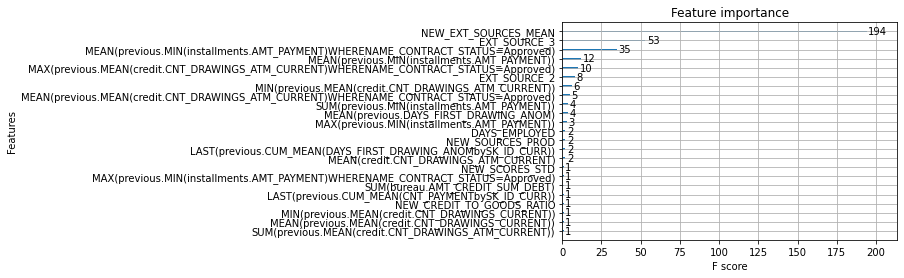

In [55]:
xgb.plot_importance(mdl_xgb, importance_type = 'weight')

In [16]:
from sklearn.inspection import permutation_importance

res = permutation_importance(mdl_xgb, X_test, y_test, n_repeats = 10, random_state = 43, n_jobs =2 )


KeyboardInterrupt: ignored

In [ ]:
ser_feat_imp_per = pd.Series(res.importances_mean, index = feat_names)

fig, ax = plt.subplots(figsize = (14,10))

ser_feat_imp_per.sort_values(ascending= False).head(50).plot.barh(yerr = res.importances_std[:50])
ax.set_title('Feature importances using permutation on full model')
ax.set_ylabel('Mean accuracy in impurity')
fig.tight_layout()
